In [1]:
# # import numpy as np
# # from scipy import sparse

# # # .. for plotting ..
# # import pylab as plt
# # # .. to generate a synthetic dataset ..
# # from sklearn import datasets

# # n_samples, n_features = 10000, 10000
# # A, b = datasets.make_regression(n_samples, n_features)

# # def FW(alpha, max_iter=100, tol=1e-8, callback=None):
# #     # .. initial estimate, could be any feasible point ..
# #     x_t = sparse.dok_matrix((n_features, 1))

# #     # .. some quantities can be precomputed ..
# #     Atb = A.T.dot(b)
# #     for it in range(max_iter):
# #         # .. compute gradient. Slightly more involved than usual because ..
# #         # .. of the use of sparse matrices ..
# #         Ax = x_t.T.dot(A.T).ravel()
# #         grad = (A.T.dot(Ax) - Atb)

# #         # .. the LMO results in a vector that is zero everywhere except for ..
# #         # .. a single index. Of this vector we only store its index and magnitude ..
# #         idx_oracle = np.argmax(np.abs(grad))
# #         mag_oracle = alpha * np.sign(-grad[idx_oracle])
# #         d_t = -x_t.copy()
# #         d_t[idx_oracle] += mag_oracle
# #         g_t = - d_t.T.dot(grad).ravel()
# #         if g_t <= tol:
# #             break
# #         q_t = A[:, idx_oracle] * mag_oracle - Ax
# #         step_size = min(q_t.dot(b - Ax) / q_t.dot(q_t), 1.)
# #         x_t += step_size * d_t
# #         if callback is not None:
# #             callback(g_t)
# #     return x_t

# # .. plot evolution of FW gap ..
# trace = []
# def callback(g_t):
#   trace.append(g_t)

# sol = FW(.5 * n_features, callback=callback)
# plt.plot(trace / trace[0], lw=3)
# plt.yscale('log')
# plt.xlabel('Number of iterations')
# plt.ylabel('Relative FW gap')
# plt.title('FW on a Lasso problem')
# plt.xlim((0, 100))
# plt.grid()
# plt.show()

# density = np.mean(sol.toarray().ravel() != 0)
# print('Density of solution: %s%%' % (density * 100))

In [1]:
import scipy.stats
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('talk')

def sample_X(d: int, a: float, n: int):
    def sample_xi(d: int, a: float):
        sigma2s = [j**(-a) for j in range(1,d+1)]
        return np.array(np.random.normal(0, np.sqrt(sigma2s))).reshape(1,-1)
    return np.concatenate([sample_xi(d, a) for i in range(n)])

class FrankWolfe:
    """
    Attributes
    ----------
    X : (n, d) matrix of arms
    XXT : (n, d, d) matrix of self interaction
    lamb : (n,1) vector of arm distribution
    A : (d, d) matrix of weighted self interactions
    """
    def __init__(self, X: np.ndarray, N: int):
        d = X.shape[1]
        n = X.shape[0]
        
        self.d = d

        self.n = n
        self.N = N
        self.X = X
        self.startup()
        return
    
    def startup(self):
        # pull first 2d arms and set lambda
        pulls = np.random.choice(list(range(self.n)), size=(2*self.d))
        values, counts_ = np.unique(pulls, return_counts=True)
        counts = []
        for i in range(self.n):
            if i in values:
                counts.append(counts_[np.argwhere(values==i)][0][0])
            else:
                counts.append(0)
        self.lamb = (np.array(counts)/(2*self.d)).reshape(-1,1)
        # start time after startup
        self.t = 2*self.d
        # the raw XXT matrix
        xs = []
        for x in self.X:
            xs.append(np.matmul(x.reshape(-1,1), x.reshape(1,-1)))
        self.XXT = np.array(xs)
        return
    
    @property
    def A(self):
        """Function of current lambda"""
        return np.sum(self.lamb.reshape(-1,1,1)*self.XXT, axis=0)
    
    @property
    def D_lamb(self):
        return -np.log(np.linalg.det(self.A))
        
    def update_for_next(self, arm_index):
        """Update lambda and time at the end of the iteration."""
        indicator = np.zeros((self.n,1))
        indicator[arm_index] = 1
        # at this lambda and t are both at their end of previous iteration state, eg t has not been updated
        self.lamb = (self.lamb*self.t + indicator)/(self.t+1)
        self.t += 1
        return
    
    def g_prime_i(self, i):
        """Compute gradient of design equation for one example's lambda"""
        return -np.matmul(np.matmul(self.X[i].reshape(1,-1), np.linalg.inv(self.A)),  self.X[i].reshape(-1,1))
    
    def take_step(self):
        # get the gradient vector
        self.g_prime = np.concatenate([self.g_prime_i(i) for i in range(self.n)])
        It = np.argmin(self.g_prime)
        self.update_for_next(It)
        # print(f'Time {self.t}, pull {It}, D = {self.D_lamb}')
        return 
    
    def run(self):
        while self.t < self.N:
            self.take_step()
        return self.lamb, self.D_lamb

In [10]:
df = pd.read_csv('/mnt/c/Users/ryanf/Desktop/learn2therm_sample_50k.csv').sample(100)

In [11]:
keep = ['local_gap_compressed_percent_id', 'query_align_cov', 'bit_score']
df_3 = df[keep].to_numpy()

In [12]:
samp = FrankWolfe(df_3, 1000)

In [13]:
samp.startup()

In [14]:
lamb, D_lamb = samp.run()

(array([97.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([0.    , 0.0332, 0.0664, 0.0996, 0.1328, 0.166 , 0.1992, 0.2324,
        0.2656, 0.2988, 0.332 ]),
 <BarContainer object of 10 artists>)

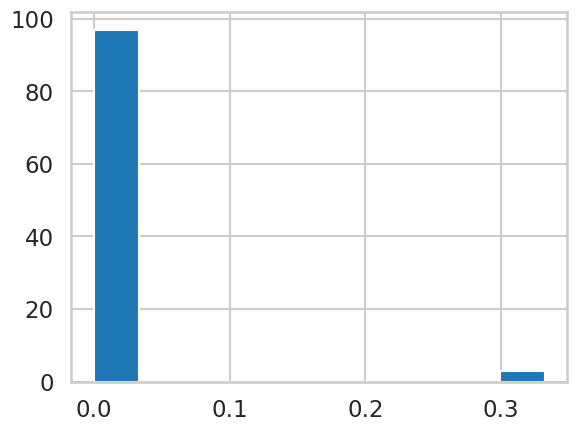

In [15]:
plt.hist(lamb)

In [16]:
lamb

array([[0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.331],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.001],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.001],
       [0.   ],
       [0.   ],
       [0.001],
       [0.   ],
       [0.001],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.001],
       [0.   ],
       [0.   ],
       [0.   ],
       [